Scene captioning with Qwen 2.5-VL

In [2]:
pip install qwen-vl-utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.4 MB/s eta 0:00:00


In [3]:
import os   # File-system helpers (paths, env vars, etc.)
import random  # Lightweight randomness e.g sample prompts
import textwrap # Nicely format long strings for display
import io  # In-memory byte streams e.g. image buffers
import requests # Simple HTTP requests for downloading assets

import numpy as np

import torch
from transformers import(
    Qwen2_5_VLForConditionalGeneration,  #Multimodal LLM (IMAGE+TEXT)
    AutoProcessor,                     #Paired tokenizer/feature-extractor
)

from PIL import Image    # Pillow: load/save/manipulate images
import matplotlib.pyplot as plt   # Quick plots in notebooks
import matplotlib.patches as patches   # Bounding-box overlays

from qwen_vl_utils import process_vision_info  #Post process Qwen outputs

import IPython.display as ipd


In [4]:
# Device and Model Load
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "Qwen/Qwen2.5-VL-3B-Instruct"

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype="auto",  # automaticall uses FP16 ON gpu, FP32 on CPU
    device_map="auto"    # dispatches layers to the available device
)

processor = AutoProcessor.from_pretrained(model_id)
print(f"Model loaded on: {model.device}")

`torch_dtype` is deprecated! Use `dtype` instead!
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

chat_template.json: 0.00B [00:00, ?B/s]

Model loaded on: cpu


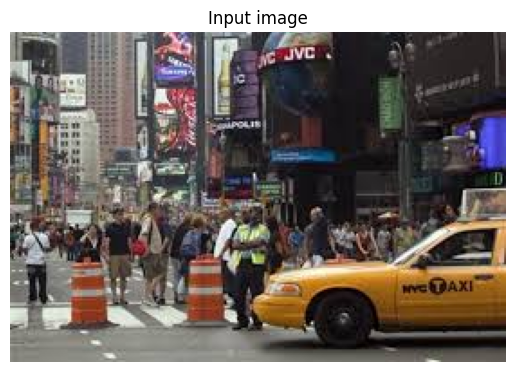

In [5]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSBkhVu7vE2C51W2wQFVpaATT1NqFIkw8blpQ&s"
img = Image.open(io.BytesIO(requests.get(url, timeout=15).content)).convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.title("Input image")
plt.show()

In [6]:
# Create a message in JSON format
# Qwne VL uses the same multi-turn message format as Qwen-2.5-Chat:

msgs = [
    { "role": "user",
     "content": [
         {"type": "image", "image": img},
         {"type": "text", "text": "Describe this image."}
     ],
    }
]

# The processor turns these messages into plain text with special tokens and extracts the visual tensoru so the model receives both modalities

In [7]:
# Build the full textual prompt that QWEN-VL expects
# msgs : list of msg dicts (roles+content, including <image> markers)
# tokenize=False : return a plain string-not token IDs-so we can
#                  combine it with image-tensors in the next processor() call
# add_generation_prompt=True : appends the "assistant is about to speak" marker
#                              (e.g. "<|im_start|>assistant\n"), which tells the model where its reply should begin
text_prompt = processor.apply_chat_template(
    msgs,
    tokenize=False,
    add_generation_prompt=True
)

print(text_prompt)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Describe this image.<|im_end|>
<|im_start|>assistant



In [8]:
# Extract vision-modalities from msgs and convert them ti model-ready tensors
#msgs: the same chat-style list you fed to apply_chat_template
#      Each dictcan include items like {"type": "image", "image": img}
#      or {"type": "video", "video": video_clip}.
#process_vision_info: project utility that
#     1) walks through every msg
#     2) finds all "imag"/"video" entries
#     3) applies the Qwen-VL visual pre-processing to ensure each
#        image is a PIL.Image (or each video is a list/tensor of frames)
#     4) returns two paralles lists/tensors:
#       - 'image_inputs' batched image tensors(or [] if none)
#       -'video_inputs'  batched video tensors (or [] if none)
# These outputs plug straight into the processor(...)' call that follows,
# ensuring the vision data is aligned with the text prompt.

image_inputs, video_inputs = process_vision_info(msgs)

In [9]:
# Generate Caption
# pack text + vision into model-ready tensors
inputs = processor(
    text=[text_prompt],  # 1-element batch containing the chat prompt string
    images=image_inputs, # list of raw PIL images (pre-processed inside processor)
    videos=video_inputs, # list of raw video clips if any
    padding=True,        # pad sequences so text/vision tokens line up in a batch
    return_tensors="pt", # return a dict of PyTorch tensors (input_ids, pixel_values, ...)
).to(model.device)       # move every tensor-text & vision-to the model's GPU/CPU

# Run inference (no gradients, pure generation)
with torch.no_grad():              # Disable autograd to save memory
  generated_ids = model.generate(  # autoregressive decoding
      **inputs,                    # unpack dict into generate(...)
      max_new_tokens=64            # cap the response at 64 tokens
  )
print(inputs.input_ids[0])
print(generated_ids)

tensor([151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
        151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151653,  74785,    419,   2168,     13,
        151645,    198, 151644,  77091,    198])
tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198, 151652, 151655, 15165

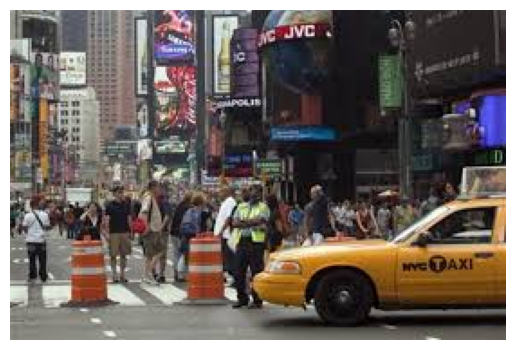

The image depicts a bustling urban scene, likely from a major city known for its vibrant nightlife
and commercial activity. The primary focus is on a busy street corner with several key elements:  1.
**Taxi**: In the foreground, there is a yellow taxi cab, which is a common sight in many cities,
especially in


In [12]:
# Decode Output
caption = processor.batch_decode(
    generated_ids[:,inputs.input_ids.shape[-1]:],
    skip_special_tokens=True
)[0]

# Display the image
plt.imshow(img)
plt.axis("off")
plt.show()

# Print caption
width = 100
wrapped_caption = textwrap.fill(caption, width)
print(wrapped_caption)